# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


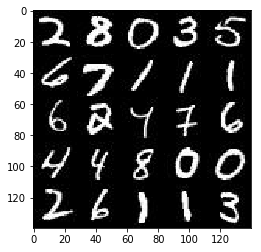

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

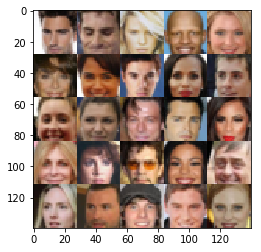

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr_rate = tf.placeholder(tf.float32, name='lr_rate')
    

    return input_real, input_z, lr_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x = tf.maximum(x*alpha, x)
        
        x = tf.layers.conv2d(x, 128, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(x*alpha, x)
        
        x = tf.reshape(x, (-1, 7*7*128))
        x = tf.layers.dense(x, 1)
        out = tf.sigmoid(x);
        return out, x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x = tf.layers.dense(z, 7*7*256)
        x = tf.reshape(x, (-1, 7, 7, 256))
        
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x*alpha, x)
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x*alpha, x)
        
        x = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(x)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    count, width, height, channels = data_shape
    input_real, input_z, lr_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr_rate, beta1)
    
    count = 0;
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                count += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr_rate: learning_rate})
                
                if count % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if count % 100 == 0:
                    show_generator_output(sess, 25, input_z, channels, data_image_mode)
        
        show_generator_output(sess, 25, input_z, channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7383... Generator Loss: 1.0660
Epoch 1/2... Discriminator Loss: 0.2371... Generator Loss: 2.2279
Epoch 1/2... Discriminator Loss: 0.8821... Generator Loss: 0.8846
Epoch 1/2... Discriminator Loss: 1.1587... Generator Loss: 1.3159
Epoch 1/2... Discriminator Loss: 1.3119... Generator Loss: 0.5352
Epoch 1/2... Discriminator Loss: 0.6799... Generator Loss: 1.4588
Epoch 1/2... Discriminator Loss: 0.7909... Generator Loss: 0.9481
Epoch 1/2... Discriminator Loss: 0.7180... Generator Loss: 0.9773
Epoch 1/2... Discriminator Loss: 0.7770... Generator Loss: 2.4105
Epoch 1/2... Discriminator Loss: 0.5159... Generator Loss: 1.4782


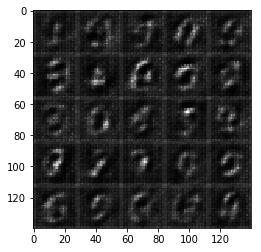

Epoch 1/2... Discriminator Loss: 0.4785... Generator Loss: 1.3012
Epoch 1/2... Discriminator Loss: 0.3961... Generator Loss: 1.6879
Epoch 1/2... Discriminator Loss: 0.3953... Generator Loss: 1.3912
Epoch 1/2... Discriminator Loss: 0.4786... Generator Loss: 3.9374
Epoch 1/2... Discriminator Loss: 1.4366... Generator Loss: 0.4133
Epoch 1/2... Discriminator Loss: 1.3900... Generator Loss: 0.5003
Epoch 1/2... Discriminator Loss: 1.1014... Generator Loss: 0.6421
Epoch 1/2... Discriminator Loss: 0.7790... Generator Loss: 0.9695
Epoch 1/2... Discriminator Loss: 0.9136... Generator Loss: 0.8400
Epoch 1/2... Discriminator Loss: 0.9659... Generator Loss: 0.7517


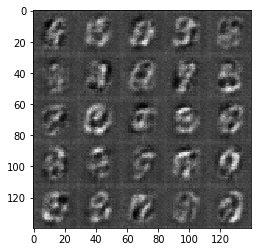

Epoch 1/2... Discriminator Loss: 1.1922... Generator Loss: 0.4768
Epoch 1/2... Discriminator Loss: 0.7241... Generator Loss: 1.7620
Epoch 1/2... Discriminator Loss: 0.7882... Generator Loss: 2.1179
Epoch 1/2... Discriminator Loss: 0.6289... Generator Loss: 1.1257
Epoch 1/2... Discriminator Loss: 1.1426... Generator Loss: 0.5082
Epoch 1/2... Discriminator Loss: 0.8278... Generator Loss: 3.0049
Epoch 1/2... Discriminator Loss: 1.1131... Generator Loss: 2.9712
Epoch 1/2... Discriminator Loss: 0.3925... Generator Loss: 2.2360
Epoch 1/2... Discriminator Loss: 0.6736... Generator Loss: 2.3450
Epoch 1/2... Discriminator Loss: 0.5138... Generator Loss: 1.5029


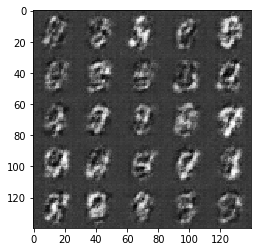

Epoch 1/2... Discriminator Loss: 0.5360... Generator Loss: 1.5794
Epoch 1/2... Discriminator Loss: 0.4672... Generator Loss: 2.0294
Epoch 1/2... Discriminator Loss: 0.6416... Generator Loss: 3.2347
Epoch 1/2... Discriminator Loss: 0.7102... Generator Loss: 1.6928
Epoch 1/2... Discriminator Loss: 0.7183... Generator Loss: 1.5861
Epoch 1/2... Discriminator Loss: 0.7794... Generator Loss: 1.0472
Epoch 1/2... Discriminator Loss: 0.5027... Generator Loss: 1.4413
Epoch 1/2... Discriminator Loss: 1.3241... Generator Loss: 0.3627
Epoch 1/2... Discriminator Loss: 0.7048... Generator Loss: 1.1852
Epoch 1/2... Discriminator Loss: 0.6487... Generator Loss: 1.0010


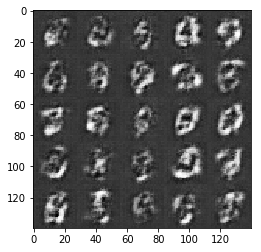

Epoch 1/2... Discriminator Loss: 0.5031... Generator Loss: 2.2395
Epoch 1/2... Discriminator Loss: 0.5545... Generator Loss: 2.3959
Epoch 1/2... Discriminator Loss: 0.7888... Generator Loss: 2.8788
Epoch 1/2... Discriminator Loss: 0.3199... Generator Loss: 2.1125
Epoch 1/2... Discriminator Loss: 1.4047... Generator Loss: 0.3178
Epoch 1/2... Discriminator Loss: 0.5918... Generator Loss: 1.1604
Epoch 1/2... Discriminator Loss: 0.3628... Generator Loss: 1.8987
Epoch 1/2... Discriminator Loss: 0.2705... Generator Loss: 2.1778
Epoch 1/2... Discriminator Loss: 0.2386... Generator Loss: 2.3991
Epoch 1/2... Discriminator Loss: 0.1727... Generator Loss: 2.7435


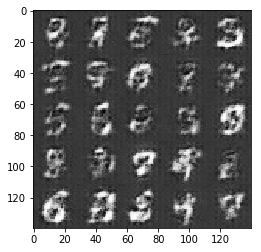

Epoch 1/2... Discriminator Loss: 1.8794... Generator Loss: 4.9178
Epoch 1/2... Discriminator Loss: 0.6349... Generator Loss: 1.4935
Epoch 1/2... Discriminator Loss: 0.5193... Generator Loss: 1.5313
Epoch 1/2... Discriminator Loss: 0.4611... Generator Loss: 1.9043
Epoch 1/2... Discriminator Loss: 0.4051... Generator Loss: 1.5044
Epoch 1/2... Discriminator Loss: 0.2591... Generator Loss: 2.5145
Epoch 1/2... Discriminator Loss: 0.2620... Generator Loss: 2.3716
Epoch 1/2... Discriminator Loss: 0.3955... Generator Loss: 3.2878
Epoch 1/2... Discriminator Loss: 0.2731... Generator Loss: 2.5324
Epoch 1/2... Discriminator Loss: 0.6962... Generator Loss: 3.0184


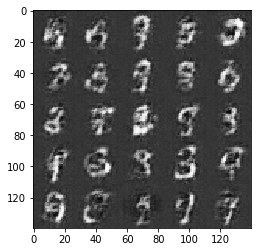

Epoch 1/2... Discriminator Loss: 0.3372... Generator Loss: 1.7893
Epoch 1/2... Discriminator Loss: 0.4543... Generator Loss: 1.2573
Epoch 1/2... Discriminator Loss: 1.0488... Generator Loss: 0.5111
Epoch 1/2... Discriminator Loss: 0.4117... Generator Loss: 1.5485
Epoch 1/2... Discriminator Loss: 0.2892... Generator Loss: 1.9940
Epoch 1/2... Discriminator Loss: 0.3014... Generator Loss: 1.7638
Epoch 1/2... Discriminator Loss: 0.3237... Generator Loss: 1.6895
Epoch 1/2... Discriminator Loss: 0.2313... Generator Loss: 2.0425
Epoch 1/2... Discriminator Loss: 0.2971... Generator Loss: 1.6464
Epoch 1/2... Discriminator Loss: 0.2840... Generator Loss: 1.8029


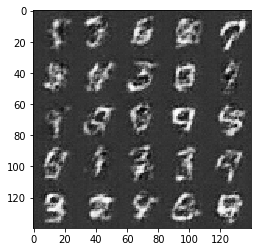

Epoch 1/2... Discriminator Loss: 0.8623... Generator Loss: 0.7859
Epoch 1/2... Discriminator Loss: 0.3371... Generator Loss: 2.3176
Epoch 1/2... Discriminator Loss: 0.1294... Generator Loss: 2.8190
Epoch 1/2... Discriminator Loss: 0.1750... Generator Loss: 3.4555
Epoch 1/2... Discriminator Loss: 0.1457... Generator Loss: 2.7219
Epoch 1/2... Discriminator Loss: 0.2208... Generator Loss: 3.4551
Epoch 1/2... Discriminator Loss: 1.9916... Generator Loss: 5.1523
Epoch 1/2... Discriminator Loss: 0.5507... Generator Loss: 1.3553
Epoch 1/2... Discriminator Loss: 0.3710... Generator Loss: 1.7419
Epoch 1/2... Discriminator Loss: 0.2687... Generator Loss: 1.9839


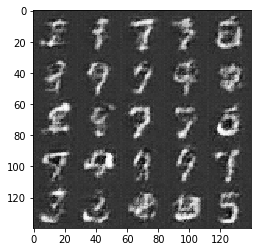

Epoch 1/2... Discriminator Loss: 0.2127... Generator Loss: 2.2786
Epoch 1/2... Discriminator Loss: 0.2199... Generator Loss: 2.1012
Epoch 1/2... Discriminator Loss: 0.2831... Generator Loss: 1.9474
Epoch 1/2... Discriminator Loss: 0.2169... Generator Loss: 2.2510
Epoch 1/2... Discriminator Loss: 0.2192... Generator Loss: 2.2187
Epoch 1/2... Discriminator Loss: 0.1601... Generator Loss: 2.4108
Epoch 1/2... Discriminator Loss: 0.2080... Generator Loss: 2.1905
Epoch 1/2... Discriminator Loss: 0.4679... Generator Loss: 1.2190
Epoch 1/2... Discriminator Loss: 0.3869... Generator Loss: 1.5780
Epoch 1/2... Discriminator Loss: 0.2803... Generator Loss: 1.8284


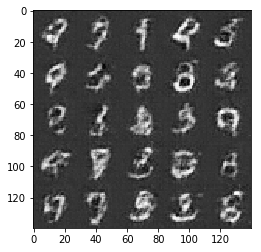

Epoch 1/2... Discriminator Loss: 0.7037... Generator Loss: 0.8699
Epoch 1/2... Discriminator Loss: 0.4119... Generator Loss: 2.4264
Epoch 1/2... Discriminator Loss: 0.2252... Generator Loss: 2.1821
Epoch 2/2... Discriminator Loss: 0.1462... Generator Loss: 2.6623
Epoch 2/2... Discriminator Loss: 0.1942... Generator Loss: 2.2506
Epoch 2/2... Discriminator Loss: 0.2620... Generator Loss: 1.7781
Epoch 2/2... Discriminator Loss: 0.1620... Generator Loss: 2.3770
Epoch 2/2... Discriminator Loss: 0.4151... Generator Loss: 1.3697
Epoch 2/2... Discriminator Loss: 0.2699... Generator Loss: 1.8942
Epoch 2/2... Discriminator Loss: 0.1829... Generator Loss: 2.2625


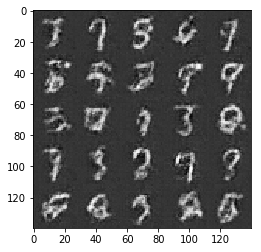

Epoch 2/2... Discriminator Loss: 0.1418... Generator Loss: 2.6802
Epoch 2/2... Discriminator Loss: 0.7698... Generator Loss: 0.8138
Epoch 2/2... Discriminator Loss: 1.6522... Generator Loss: 0.7732
Epoch 2/2... Discriminator Loss: 0.8216... Generator Loss: 1.9779
Epoch 2/2... Discriminator Loss: 0.4637... Generator Loss: 1.8421
Epoch 2/2... Discriminator Loss: 0.6641... Generator Loss: 0.9551
Epoch 2/2... Discriminator Loss: 0.5903... Generator Loss: 1.1108
Epoch 2/2... Discriminator Loss: 0.4783... Generator Loss: 1.4682
Epoch 2/2... Discriminator Loss: 0.4209... Generator Loss: 1.4758
Epoch 2/2... Discriminator Loss: 0.3841... Generator Loss: 1.6807


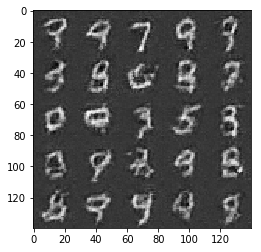

Epoch 2/2... Discriminator Loss: 0.3311... Generator Loss: 1.8100
Epoch 2/2... Discriminator Loss: 0.2670... Generator Loss: 2.1136
Epoch 2/2... Discriminator Loss: 0.3045... Generator Loss: 1.9120
Epoch 2/2... Discriminator Loss: 0.3805... Generator Loss: 1.5803
Epoch 2/2... Discriminator Loss: 0.4265... Generator Loss: 1.5423
Epoch 2/2... Discriminator Loss: 0.2499... Generator Loss: 2.1804
Epoch 2/2... Discriminator Loss: 0.3296... Generator Loss: 1.6695
Epoch 2/2... Discriminator Loss: 0.2797... Generator Loss: 2.0180
Epoch 2/2... Discriminator Loss: 0.3079... Generator Loss: 1.8123
Epoch 2/2... Discriminator Loss: 0.2246... Generator Loss: 2.2413


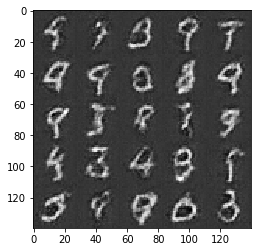

Epoch 2/2... Discriminator Loss: 0.5731... Generator Loss: 1.0672
Epoch 2/2... Discriminator Loss: 0.3638... Generator Loss: 1.6789
Epoch 2/2... Discriminator Loss: 0.1697... Generator Loss: 2.6601
Epoch 2/2... Discriminator Loss: 1.4537... Generator Loss: 3.1699
Epoch 2/2... Discriminator Loss: 0.5660... Generator Loss: 1.3175
Epoch 2/2... Discriminator Loss: 0.4382... Generator Loss: 1.3445
Epoch 2/2... Discriminator Loss: 0.5208... Generator Loss: 1.4697
Epoch 2/2... Discriminator Loss: 0.4957... Generator Loss: 1.3220
Epoch 2/2... Discriminator Loss: 0.4334... Generator Loss: 1.3774
Epoch 2/2... Discriminator Loss: 1.2740... Generator Loss: 0.3949


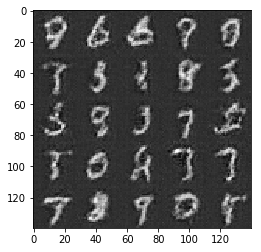

Epoch 2/2... Discriminator Loss: 0.4222... Generator Loss: 1.9652
Epoch 2/2... Discriminator Loss: 0.3779... Generator Loss: 2.0176
Epoch 2/2... Discriminator Loss: 0.3392... Generator Loss: 1.7697
Epoch 2/2... Discriminator Loss: 0.3289... Generator Loss: 1.8523
Epoch 2/2... Discriminator Loss: 0.2811... Generator Loss: 1.8481
Epoch 2/2... Discriminator Loss: 0.1801... Generator Loss: 3.1675
Epoch 2/2... Discriminator Loss: 0.4181... Generator Loss: 1.5407
Epoch 2/2... Discriminator Loss: 0.3498... Generator Loss: 1.6496
Epoch 2/2... Discriminator Loss: 0.2277... Generator Loss: 2.1037
Epoch 2/2... Discriminator Loss: 0.3185... Generator Loss: 1.8876


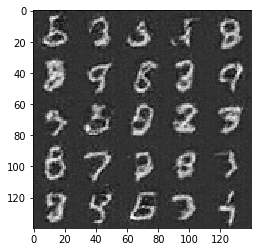

Epoch 2/2... Discriminator Loss: 0.3001... Generator Loss: 1.7853
Epoch 2/2... Discriminator Loss: 0.2851... Generator Loss: 1.8106
Epoch 2/2... Discriminator Loss: 0.3428... Generator Loss: 3.5332
Epoch 2/2... Discriminator Loss: 0.1539... Generator Loss: 2.6697
Epoch 2/2... Discriminator Loss: 0.1321... Generator Loss: 3.1731
Epoch 2/2... Discriminator Loss: 0.2617... Generator Loss: 1.8782
Epoch 2/2... Discriminator Loss: 0.2092... Generator Loss: 2.2778
Epoch 2/2... Discriminator Loss: 0.9790... Generator Loss: 0.6054
Epoch 2/2... Discriminator Loss: 0.3466... Generator Loss: 2.0223
Epoch 2/2... Discriminator Loss: 0.3803... Generator Loss: 1.4834


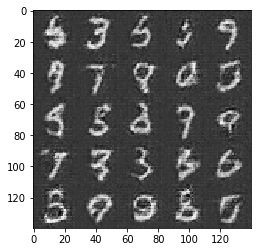

Epoch 2/2... Discriminator Loss: 0.1841... Generator Loss: 2.8291
Epoch 2/2... Discriminator Loss: 0.1913... Generator Loss: 2.3795
Epoch 2/2... Discriminator Loss: 0.3293... Generator Loss: 1.6588
Epoch 2/2... Discriminator Loss: 0.3055... Generator Loss: 1.6491
Epoch 2/2... Discriminator Loss: 0.2270... Generator Loss: 2.2404
Epoch 2/2... Discriminator Loss: 0.1512... Generator Loss: 2.5652
Epoch 2/2... Discriminator Loss: 0.1629... Generator Loss: 2.7256
Epoch 2/2... Discriminator Loss: 0.1274... Generator Loss: 3.6328
Epoch 2/2... Discriminator Loss: 0.1130... Generator Loss: 3.3441
Epoch 2/2... Discriminator Loss: 0.2362... Generator Loss: 1.9948


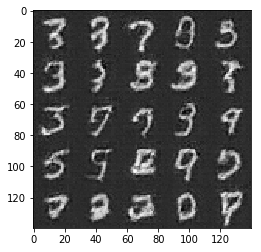

Epoch 2/2... Discriminator Loss: 0.1497... Generator Loss: 2.5619
Epoch 2/2... Discriminator Loss: 7.1312... Generator Loss: 0.0048
Epoch 2/2... Discriminator Loss: 1.1071... Generator Loss: 4.0365
Epoch 2/2... Discriminator Loss: 0.6041... Generator Loss: 1.8491
Epoch 2/2... Discriminator Loss: 0.4440... Generator Loss: 1.7525
Epoch 2/2... Discriminator Loss: 0.5504... Generator Loss: 2.0103
Epoch 2/2... Discriminator Loss: 0.3897... Generator Loss: 1.9628
Epoch 2/2... Discriminator Loss: 0.2729... Generator Loss: 2.1580
Epoch 2/2... Discriminator Loss: 0.5497... Generator Loss: 1.1232
Epoch 2/2... Discriminator Loss: 0.2557... Generator Loss: 2.1024


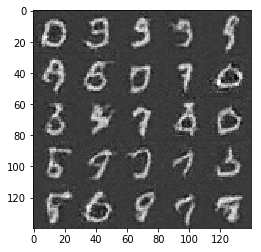

Epoch 2/2... Discriminator Loss: 0.3573... Generator Loss: 2.7735
Epoch 2/2... Discriminator Loss: 0.2729... Generator Loss: 2.0410
Epoch 2/2... Discriminator Loss: 0.2872... Generator Loss: 1.9139
Epoch 2/2... Discriminator Loss: 0.1890... Generator Loss: 3.5438
Epoch 2/2... Discriminator Loss: 0.2535... Generator Loss: 2.3918
Epoch 2/2... Discriminator Loss: 0.2689... Generator Loss: 3.1278
Epoch 2/2... Discriminator Loss: 0.2475... Generator Loss: 3.0352
Epoch 2/2... Discriminator Loss: 0.2982... Generator Loss: 1.8421
Epoch 2/2... Discriminator Loss: 0.1670... Generator Loss: 2.4982
Epoch 2/2... Discriminator Loss: 0.2763... Generator Loss: 2.2028


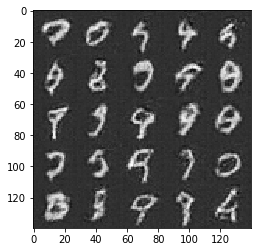

Epoch 2/2... Discriminator Loss: 0.2380... Generator Loss: 2.1136
Epoch 2/2... Discriminator Loss: 0.2363... Generator Loss: 1.8684
Epoch 2/2... Discriminator Loss: 0.0987... Generator Loss: 3.3123
Epoch 2/2... Discriminator Loss: 0.1389... Generator Loss: 2.6275
Epoch 2/2... Discriminator Loss: 0.0820... Generator Loss: 3.2902
Epoch 2/2... Discriminator Loss: 0.1849... Generator Loss: 2.4380
Epoch 2/2... Discriminator Loss: 0.4288... Generator Loss: 1.3275


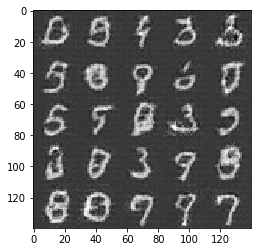

In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.4388... Generator Loss: 0.2183
Epoch 1/1... Discriminator Loss: 1.9795... Generator Loss: 0.3718
Epoch 1/1... Discriminator Loss: 1.7555... Generator Loss: 0.5900
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.0682... Generator Loss: 1.0943
Epoch 1/1... Discriminator Loss: 0.6703... Generator Loss: 1.1353
Epoch 1/1... Discriminator Loss: 0.4488... Generator Loss: 1.9088
Epoch 1/1... Discriminator Loss: 0.3255... Generator Loss: 1.9531
Epoch 1/1... Discriminator Loss: 0.2817... Generator Loss: 2.0156
Epoch 1/1... Discriminator Loss: 0.1893... Generator Loss: 2.2603


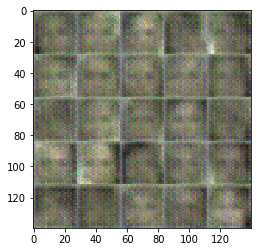

Epoch 1/1... Discriminator Loss: 0.7526... Generator Loss: 5.1771
Epoch 1/1... Discriminator Loss: 0.2090... Generator Loss: 5.3427
Epoch 1/1... Discriminator Loss: 0.5806... Generator Loss: 1.4300
Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 8.9912
Epoch 1/1... Discriminator Loss: 0.7942... Generator Loss: 1.2074
Epoch 1/1... Discriminator Loss: 0.4112... Generator Loss: 2.5580
Epoch 1/1... Discriminator Loss: 0.2926... Generator Loss: 3.3766
Epoch 1/1... Discriminator Loss: 0.7405... Generator Loss: 13.9853
Epoch 1/1... Discriminator Loss: 0.2082... Generator Loss: 3.2221
Epoch 1/1... Discriminator Loss: 2.3699... Generator Loss: 0.2011


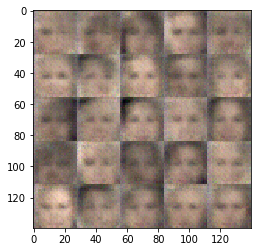

Epoch 1/1... Discriminator Loss: 0.2600... Generator Loss: 3.1603
Epoch 1/1... Discriminator Loss: 0.2865... Generator Loss: 2.1483
Epoch 1/1... Discriminator Loss: 0.4210... Generator Loss: 2.9915
Epoch 1/1... Discriminator Loss: 0.0721... Generator Loss: 11.2987
Epoch 1/1... Discriminator Loss: 0.6026... Generator Loss: 1.0441
Epoch 1/1... Discriminator Loss: 0.1578... Generator Loss: 6.3715
Epoch 1/1... Discriminator Loss: 0.4181... Generator Loss: 5.6404
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 4.2591
Epoch 1/1... Discriminator Loss: 0.7008... Generator Loss: 0.9068
Epoch 1/1... Discriminator Loss: 2.1318... Generator Loss: 0.1460


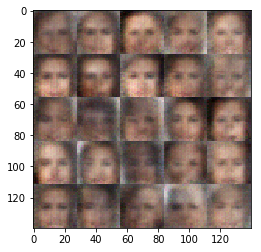

Epoch 1/1... Discriminator Loss: 0.2193... Generator Loss: 5.3861
Epoch 1/1... Discriminator Loss: 0.3558... Generator Loss: 1.6299
Epoch 1/1... Discriminator Loss: 1.6016... Generator Loss: 0.2654
Epoch 1/1... Discriminator Loss: 0.4496... Generator Loss: 3.6860
Epoch 1/1... Discriminator Loss: 0.2555... Generator Loss: 2.6782
Epoch 1/1... Discriminator Loss: 0.1805... Generator Loss: 4.6130
Epoch 1/1... Discriminator Loss: 0.1894... Generator Loss: 11.9581
Epoch 1/1... Discriminator Loss: 0.2413... Generator Loss: 2.2159
Epoch 1/1... Discriminator Loss: 0.1052... Generator Loss: 6.6228
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 0.4610


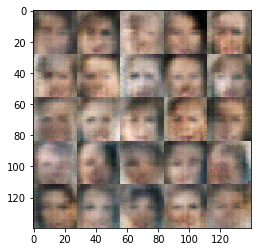

Epoch 1/1... Discriminator Loss: 0.2693... Generator Loss: 1.8659
Epoch 1/1... Discriminator Loss: 0.5229... Generator Loss: 1.1328
Epoch 1/1... Discriminator Loss: 0.3581... Generator Loss: 5.0943
Epoch 1/1... Discriminator Loss: 0.1164... Generator Loss: 8.4079
Epoch 1/1... Discriminator Loss: 0.8765... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 7.5690
Epoch 1/1... Discriminator Loss: 0.1704... Generator Loss: 5.8636
Epoch 1/1... Discriminator Loss: 0.3600... Generator Loss: 1.4755
Epoch 1/1... Discriminator Loss: 0.4289... Generator Loss: 1.6012
Epoch 1/1... Discriminator Loss: 0.4628... Generator Loss: 1.5767


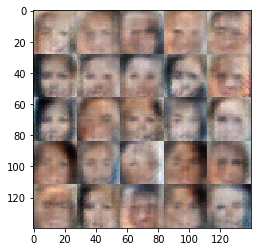

Epoch 1/1... Discriminator Loss: 0.0663... Generator Loss: 5.9330
Epoch 1/1... Discriminator Loss: 0.6878... Generator Loss: 0.9446
Epoch 1/1... Discriminator Loss: 0.2100... Generator Loss: 4.4102
Epoch 1/1... Discriminator Loss: 2.3205... Generator Loss: 0.1326
Epoch 1/1... Discriminator Loss: 0.1015... Generator Loss: 8.2474
Epoch 1/1... Discriminator Loss: 0.4370... Generator Loss: 5.0193
Epoch 1/1... Discriminator Loss: 0.6242... Generator Loss: 1.1660
Epoch 1/1... Discriminator Loss: 0.3238... Generator Loss: 2.8376
Epoch 1/1... Discriminator Loss: 0.1439... Generator Loss: 4.9596
Epoch 1/1... Discriminator Loss: 0.1157... Generator Loss: 6.4377


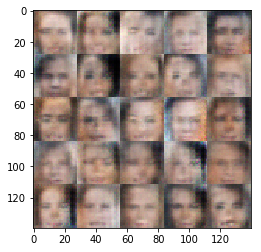

Epoch 1/1... Discriminator Loss: 0.5719... Generator Loss: 1.3765
Epoch 1/1... Discriminator Loss: 0.5474... Generator Loss: 10.3205
Epoch 1/1... Discriminator Loss: 0.2250... Generator Loss: 10.3286
Epoch 1/1... Discriminator Loss: 0.5703... Generator Loss: 1.3225
Epoch 1/1... Discriminator Loss: 0.2055... Generator Loss: 4.7461
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.4323
Epoch 1/1... Discriminator Loss: 0.1733... Generator Loss: 2.8650
Epoch 1/1... Discriminator Loss: 0.1625... Generator Loss: 3.7945
Epoch 1/1... Discriminator Loss: 0.3862... Generator Loss: 7.8827
Epoch 1/1... Discriminator Loss: 0.9481... Generator Loss: 4.9281


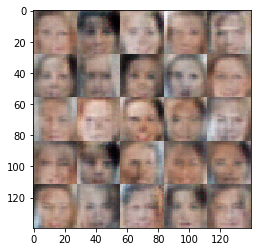

Epoch 1/1... Discriminator Loss: 0.1601... Generator Loss: 3.8630
Epoch 1/1... Discriminator Loss: 0.4239... Generator Loss: 1.7472
Epoch 1/1... Discriminator Loss: 0.3057... Generator Loss: 2.4989
Epoch 1/1... Discriminator Loss: 0.2187... Generator Loss: 4.3852
Epoch 1/1... Discriminator Loss: 0.2748... Generator Loss: 4.8830
Epoch 1/1... Discriminator Loss: 0.1059... Generator Loss: 4.4532
Epoch 1/1... Discriminator Loss: 0.1723... Generator Loss: 4.0311
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.4745
Epoch 1/1... Discriminator Loss: 0.1109... Generator Loss: 10.3456
Epoch 1/1... Discriminator Loss: 0.1455... Generator Loss: 4.7420


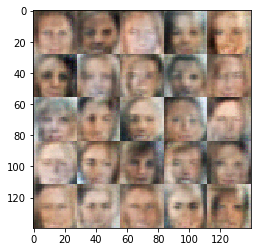

Epoch 1/1... Discriminator Loss: 0.1092... Generator Loss: 5.1596
Epoch 1/1... Discriminator Loss: 0.7424... Generator Loss: 0.8899
Epoch 1/1... Discriminator Loss: 0.0697... Generator Loss: 12.0775
Epoch 1/1... Discriminator Loss: 0.7853... Generator Loss: 0.9440
Epoch 1/1... Discriminator Loss: 0.0748... Generator Loss: 12.0877
Epoch 1/1... Discriminator Loss: 0.1129... Generator Loss: 9.0892
Epoch 1/1... Discriminator Loss: 0.1327... Generator Loss: 10.0600
Epoch 1/1... Discriminator Loss: 0.1141... Generator Loss: 5.1221
Epoch 1/1... Discriminator Loss: 0.3210... Generator Loss: 1.9987
Epoch 1/1... Discriminator Loss: 0.1965... Generator Loss: 12.3913


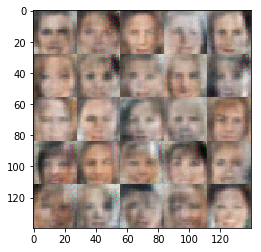

Epoch 1/1... Discriminator Loss: 0.1512... Generator Loss: 5.4255
Epoch 1/1... Discriminator Loss: 0.1046... Generator Loss: 5.7162
Epoch 1/1... Discriminator Loss: 0.1440... Generator Loss: 8.3257
Epoch 1/1... Discriminator Loss: 0.2428... Generator Loss: 2.7151
Epoch 1/1... Discriminator Loss: 0.5172... Generator Loss: 9.2073
Epoch 1/1... Discriminator Loss: 0.1347... Generator Loss: 7.7318
Epoch 1/1... Discriminator Loss: 0.1713... Generator Loss: 9.5772
Epoch 1/1... Discriminator Loss: 0.5099... Generator Loss: 2.2964
Epoch 1/1... Discriminator Loss: 0.1843... Generator Loss: 4.9489
Epoch 1/1... Discriminator Loss: 0.2979... Generator Loss: 5.4308


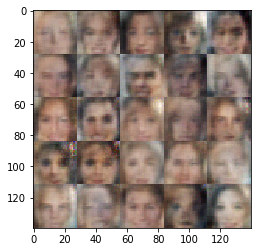

Epoch 1/1... Discriminator Loss: 0.1286... Generator Loss: 5.0211
Epoch 1/1... Discriminator Loss: 0.1854... Generator Loss: 6.8300
Epoch 1/1... Discriminator Loss: 0.1178... Generator Loss: 8.5399
Epoch 1/1... Discriminator Loss: 0.1127... Generator Loss: 4.1172
Epoch 1/1... Discriminator Loss: 0.1750... Generator Loss: 9.0541
Epoch 1/1... Discriminator Loss: 0.3807... Generator Loss: 2.4818
Epoch 1/1... Discriminator Loss: 0.1468... Generator Loss: 7.9869
Epoch 1/1... Discriminator Loss: 0.5993... Generator Loss: 1.6789
Epoch 1/1... Discriminator Loss: 0.2883... Generator Loss: 5.9666
Epoch 1/1... Discriminator Loss: 0.2999... Generator Loss: 2.4676


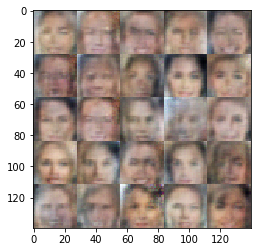

Epoch 1/1... Discriminator Loss: 0.1308... Generator Loss: 4.2688
Epoch 1/1... Discriminator Loss: 0.1325... Generator Loss: 6.1666
Epoch 1/1... Discriminator Loss: 0.0987... Generator Loss: 13.3852
Epoch 1/1... Discriminator Loss: 0.1557... Generator Loss: 9.2270
Epoch 1/1... Discriminator Loss: 0.6007... Generator Loss: 1.6028
Epoch 1/1... Discriminator Loss: 0.0789... Generator Loss: 9.4098
Epoch 1/1... Discriminator Loss: 0.1092... Generator Loss: 6.8625
Epoch 1/1... Discriminator Loss: 0.3451... Generator Loss: 2.7373
Epoch 1/1... Discriminator Loss: 0.2319... Generator Loss: 6.3110
Epoch 1/1... Discriminator Loss: 0.1300... Generator Loss: 4.5302


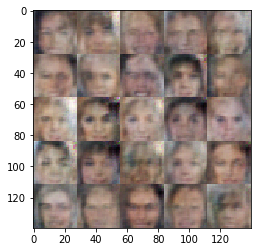

Epoch 1/1... Discriminator Loss: 0.2462... Generator Loss: 4.4624
Epoch 1/1... Discriminator Loss: 0.1081... Generator Loss: 6.3396
Epoch 1/1... Discriminator Loss: 0.0761... Generator Loss: 8.6432
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 11.2258
Epoch 1/1... Discriminator Loss: 1.0406... Generator Loss: 2.3519
Epoch 1/1... Discriminator Loss: 0.3087... Generator Loss: 11.4804
Epoch 1/1... Discriminator Loss: 0.0628... Generator Loss: 9.6566
Epoch 1/1... Discriminator Loss: 0.1460... Generator Loss: 6.9778
Epoch 1/1... Discriminator Loss: 0.5234... Generator Loss: 2.9399
Epoch 1/1... Discriminator Loss: 0.0666... Generator Loss: 8.6040


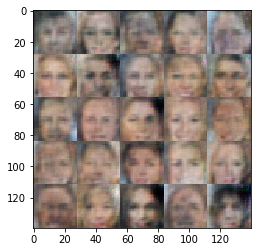

Epoch 1/1... Discriminator Loss: 0.0991... Generator Loss: 8.7428
Epoch 1/1... Discriminator Loss: 0.1376... Generator Loss: 10.2896
Epoch 1/1... Discriminator Loss: 0.0605... Generator Loss: 11.1823
Epoch 1/1... Discriminator Loss: 0.0575... Generator Loss: 11.1694
Epoch 1/1... Discriminator Loss: 0.1105... Generator Loss: 10.5534
Epoch 1/1... Discriminator Loss: 0.0591... Generator Loss: 9.7953
Epoch 1/1... Discriminator Loss: 0.0537... Generator Loss: 10.9760
Epoch 1/1... Discriminator Loss: 0.0713... Generator Loss: 10.2812
Epoch 1/1... Discriminator Loss: 0.0835... Generator Loss: 13.4962
Epoch 1/1... Discriminator Loss: 0.3312... Generator Loss: 3.3951


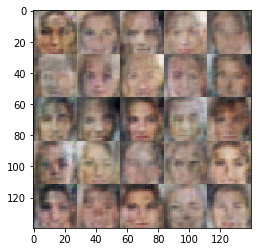

Epoch 1/1... Discriminator Loss: 0.1466... Generator Loss: 5.9860
Epoch 1/1... Discriminator Loss: 0.5900... Generator Loss: 5.5217
Epoch 1/1... Discriminator Loss: 0.2876... Generator Loss: 11.3847
Epoch 1/1... Discriminator Loss: 0.0802... Generator Loss: 8.0754
Epoch 1/1... Discriminator Loss: 0.1039... Generator Loss: 10.6936
Epoch 1/1... Discriminator Loss: 0.3056... Generator Loss: 4.4852
Epoch 1/1... Discriminator Loss: 0.8188... Generator Loss: 11.0281
Epoch 1/1... Discriminator Loss: 0.1208... Generator Loss: 6.8496
Epoch 1/1... Discriminator Loss: 0.5159... Generator Loss: 1.5662
Epoch 1/1... Discriminator Loss: 0.5785... Generator Loss: 1.3634


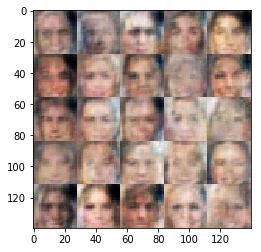

Epoch 1/1... Discriminator Loss: 0.3464... Generator Loss: 13.2972
Epoch 1/1... Discriminator Loss: 0.0794... Generator Loss: 10.7014
Epoch 1/1... Discriminator Loss: 0.1157... Generator Loss: 9.6106
Epoch 1/1... Discriminator Loss: 0.1255... Generator Loss: 11.3151
Epoch 1/1... Discriminator Loss: 0.3094... Generator Loss: 5.6080
Epoch 1/1... Discriminator Loss: 0.2969... Generator Loss: 3.1268
Epoch 1/1... Discriminator Loss: 0.0766... Generator Loss: 4.6444
Epoch 1/1... Discriminator Loss: 0.1383... Generator Loss: 4.9843
Epoch 1/1... Discriminator Loss: 0.5864... Generator Loss: 2.8352
Epoch 1/1... Discriminator Loss: 0.1846... Generator Loss: 5.4547


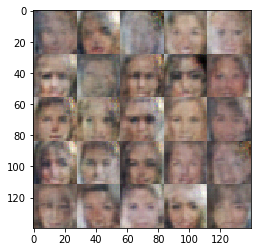

Epoch 1/1... Discriminator Loss: 0.0841... Generator Loss: 10.5718
Epoch 1/1... Discriminator Loss: 0.4637... Generator Loss: 1.9182
Epoch 1/1... Discriminator Loss: 1.0612... Generator Loss: 1.0611
Epoch 1/1... Discriminator Loss: 0.0795... Generator Loss: 10.0838
Epoch 1/1... Discriminator Loss: 0.2280... Generator Loss: 14.9692
Epoch 1/1... Discriminator Loss: 0.5306... Generator Loss: 3.6454
Epoch 1/1... Discriminator Loss: 0.2583... Generator Loss: 5.6799
Epoch 1/1... Discriminator Loss: 0.1923... Generator Loss: 11.1453
Epoch 1/1... Discriminator Loss: 0.0725... Generator Loss: 10.9834
Epoch 1/1... Discriminator Loss: 0.2847... Generator Loss: 3.2782


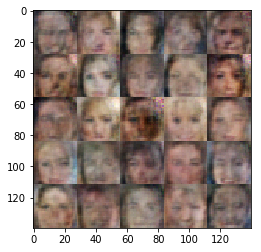

Epoch 1/1... Discriminator Loss: 4.1906... Generator Loss: 2.3411
Epoch 1/1... Discriminator Loss: 0.2363... Generator Loss: 5.6399
Epoch 1/1... Discriminator Loss: 0.1102... Generator Loss: 9.4834
Epoch 1/1... Discriminator Loss: 0.3404... Generator Loss: 2.6715
Epoch 1/1... Discriminator Loss: 0.3631... Generator Loss: 2.8254
Epoch 1/1... Discriminator Loss: 0.5318... Generator Loss: 1.5518
Epoch 1/1... Discriminator Loss: 0.3670... Generator Loss: 3.6706
Epoch 1/1... Discriminator Loss: 0.2235... Generator Loss: 6.5223
Epoch 1/1... Discriminator Loss: 0.3050... Generator Loss: 7.2818
Epoch 1/1... Discriminator Loss: 0.1189... Generator Loss: 7.9744


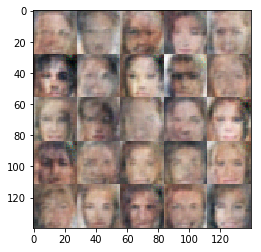

Epoch 1/1... Discriminator Loss: 0.2364... Generator Loss: 5.8633
Epoch 1/1... Discriminator Loss: 0.1558... Generator Loss: 7.2761
Epoch 1/1... Discriminator Loss: 0.5150... Generator Loss: 5.6118
Epoch 1/1... Discriminator Loss: 0.5207... Generator Loss: 5.9833
Epoch 1/1... Discriminator Loss: 0.2913... Generator Loss: 4.2981
Epoch 1/1... Discriminator Loss: 0.2506... Generator Loss: 3.1163
Epoch 1/1... Discriminator Loss: 0.0796... Generator Loss: 12.6156
Epoch 1/1... Discriminator Loss: 0.1191... Generator Loss: 7.8041
Epoch 1/1... Discriminator Loss: 0.7362... Generator Loss: 1.0214
Epoch 1/1... Discriminator Loss: 0.1820... Generator Loss: 14.5709


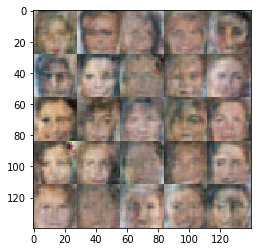

Epoch 1/1... Discriminator Loss: 0.7877... Generator Loss: 1.4085
Epoch 1/1... Discriminator Loss: 0.0806... Generator Loss: 8.0783
Epoch 1/1... Discriminator Loss: 0.0815... Generator Loss: 12.8729
Epoch 1/1... Discriminator Loss: 0.1546... Generator Loss: 9.1027
Epoch 1/1... Discriminator Loss: 0.5034... Generator Loss: 5.6490
Epoch 1/1... Discriminator Loss: 0.1728... Generator Loss: 4.4049
Epoch 1/1... Discriminator Loss: 0.1800... Generator Loss: 11.0907
Epoch 1/1... Discriminator Loss: 0.2943... Generator Loss: 7.4656
Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 8.4761
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 4.8504


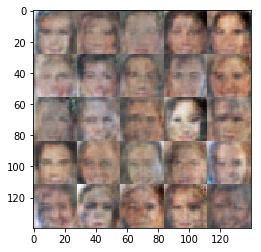

Epoch 1/1... Discriminator Loss: 0.3181... Generator Loss: 4.4088
Epoch 1/1... Discriminator Loss: 0.1206... Generator Loss: 13.0668
Epoch 1/1... Discriminator Loss: 0.1896... Generator Loss: 9.5100
Epoch 1/1... Discriminator Loss: 0.2482... Generator Loss: 7.5127
Epoch 1/1... Discriminator Loss: 0.1746... Generator Loss: 8.7592
Epoch 1/1... Discriminator Loss: 0.1741... Generator Loss: 6.2121
Epoch 1/1... Discriminator Loss: 0.2657... Generator Loss: 4.4974
Epoch 1/1... Discriminator Loss: 0.3559... Generator Loss: 4.2394
Epoch 1/1... Discriminator Loss: 0.7043... Generator Loss: 1.9844
Epoch 1/1... Discriminator Loss: 0.6258... Generator Loss: 1.7565


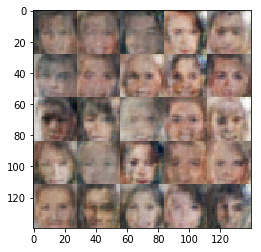

Epoch 1/1... Discriminator Loss: 0.1329... Generator Loss: 8.3731
Epoch 1/1... Discriminator Loss: 0.1079... Generator Loss: 9.7382
Epoch 1/1... Discriminator Loss: 0.6964... Generator Loss: 1.4652
Epoch 1/1... Discriminator Loss: 0.3800... Generator Loss: 5.5977
Epoch 1/1... Discriminator Loss: 0.2044... Generator Loss: 10.5912
Epoch 1/1... Discriminator Loss: 0.7010... Generator Loss: 2.4767
Epoch 1/1... Discriminator Loss: 0.2751... Generator Loss: 8.6539
Epoch 1/1... Discriminator Loss: 0.3115... Generator Loss: 3.8122
Epoch 1/1... Discriminator Loss: 3.8076... Generator Loss: 0.1036
Epoch 1/1... Discriminator Loss: 0.4841... Generator Loss: 2.3208


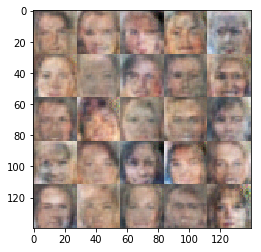

Epoch 1/1... Discriminator Loss: 0.4578... Generator Loss: 2.1100
Epoch 1/1... Discriminator Loss: 0.2905... Generator Loss: 5.2884
Epoch 1/1... Discriminator Loss: 0.1985... Generator Loss: 4.6398
Epoch 1/1... Discriminator Loss: 0.3253... Generator Loss: 3.5977
Epoch 1/1... Discriminator Loss: 0.4102... Generator Loss: 1.6761
Epoch 1/1... Discriminator Loss: 0.1787... Generator Loss: 8.3252
Epoch 1/1... Discriminator Loss: 0.3467... Generator Loss: 6.7989
Epoch 1/1... Discriminator Loss: 0.2800... Generator Loss: 6.8611
Epoch 1/1... Discriminator Loss: 0.2370... Generator Loss: 9.9448
Epoch 1/1... Discriminator Loss: 0.2316... Generator Loss: 4.3521


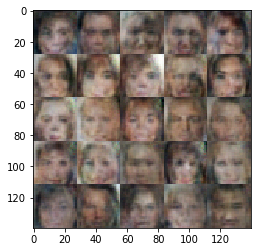

Epoch 1/1... Discriminator Loss: 0.1321... Generator Loss: 7.9819
Epoch 1/1... Discriminator Loss: 0.3905... Generator Loss: 2.3942
Epoch 1/1... Discriminator Loss: 0.1142... Generator Loss: 6.3620
Epoch 1/1... Discriminator Loss: 0.1102... Generator Loss: 15.9580
Epoch 1/1... Discriminator Loss: 0.1654... Generator Loss: 7.5051
Epoch 1/1... Discriminator Loss: 0.4066... Generator Loss: 9.5838
Epoch 1/1... Discriminator Loss: 0.2953... Generator Loss: 3.4830
Epoch 1/1... Discriminator Loss: 2.9745... Generator Loss: 12.0780
Epoch 1/1... Discriminator Loss: 0.6496... Generator Loss: 3.6285
Epoch 1/1... Discriminator Loss: 0.2491... Generator Loss: 9.2714


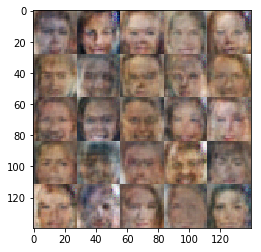

Epoch 1/1... Discriminator Loss: 0.5708... Generator Loss: 2.3156
Epoch 1/1... Discriminator Loss: 0.4346... Generator Loss: 5.3724
Epoch 1/1... Discriminator Loss: 0.3934... Generator Loss: 2.5521
Epoch 1/1... Discriminator Loss: 0.2577... Generator Loss: 10.5300
Epoch 1/1... Discriminator Loss: 0.2484... Generator Loss: 6.9837
Epoch 1/1... Discriminator Loss: 0.1491... Generator Loss: 9.6424
Epoch 1/1... Discriminator Loss: 0.2355... Generator Loss: 3.9590
Epoch 1/1... Discriminator Loss: 0.2178... Generator Loss: 6.4394
Epoch 1/1... Discriminator Loss: 0.3772... Generator Loss: 4.8126
Epoch 1/1... Discriminator Loss: 0.3885... Generator Loss: 2.2645


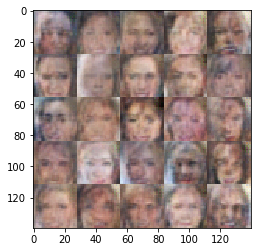

Epoch 1/1... Discriminator Loss: 0.7938... Generator Loss: 2.5069
Epoch 1/1... Discriminator Loss: 0.2275... Generator Loss: 4.6203
Epoch 1/1... Discriminator Loss: 0.4659... Generator Loss: 5.8880
Epoch 1/1... Discriminator Loss: 0.7639... Generator Loss: 5.9751
Epoch 1/1... Discriminator Loss: 0.2897... Generator Loss: 7.6554
Epoch 1/1... Discriminator Loss: 0.4536... Generator Loss: 2.0421
Epoch 1/1... Discriminator Loss: 0.6104... Generator Loss: 1.2315
Epoch 1/1... Discriminator Loss: 0.4154... Generator Loss: 3.7336
Epoch 1/1... Discriminator Loss: 0.3173... Generator Loss: 6.8403
Epoch 1/1... Discriminator Loss: 0.3594... Generator Loss: 2.9622


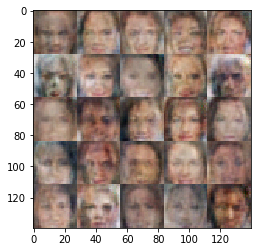

Epoch 1/1... Discriminator Loss: 0.4874... Generator Loss: 4.6051
Epoch 1/1... Discriminator Loss: 0.4831... Generator Loss: 1.7753
Epoch 1/1... Discriminator Loss: 0.1230... Generator Loss: 5.9650
Epoch 1/1... Discriminator Loss: 0.2997... Generator Loss: 3.7799
Epoch 1/1... Discriminator Loss: 0.3058... Generator Loss: 10.3386
Epoch 1/1... Discriminator Loss: 0.4083... Generator Loss: 2.0307
Epoch 1/1... Discriminator Loss: 1.0084... Generator Loss: 1.7919
Epoch 1/1... Discriminator Loss: 0.0927... Generator Loss: 6.1990
Epoch 1/1... Discriminator Loss: 0.1623... Generator Loss: 4.4171
Epoch 1/1... Discriminator Loss: 0.1119... Generator Loss: 11.9103


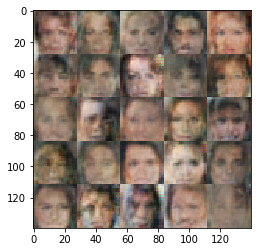

Epoch 1/1... Discriminator Loss: 0.3550... Generator Loss: 3.0333
Epoch 1/1... Discriminator Loss: 3.7956... Generator Loss: 5.4370
Epoch 1/1... Discriminator Loss: 0.4182... Generator Loss: 2.0712
Epoch 1/1... Discriminator Loss: 0.3036... Generator Loss: 3.0435
Epoch 1/1... Discriminator Loss: 0.4096... Generator Loss: 2.6307
Epoch 1/1... Discriminator Loss: 1.0473... Generator Loss: 1.2351
Epoch 1/1... Discriminator Loss: 0.2901... Generator Loss: 6.3150
Epoch 1/1... Discriminator Loss: 0.2524... Generator Loss: 5.2920
Epoch 1/1... Discriminator Loss: 0.2508... Generator Loss: 4.7479
Epoch 1/1... Discriminator Loss: 0.1584... Generator Loss: 10.9353


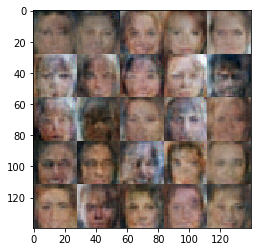

Epoch 1/1... Discriminator Loss: 0.7770... Generator Loss: 3.2920
Epoch 1/1... Discriminator Loss: 0.9646... Generator Loss: 14.6034
Epoch 1/1... Discriminator Loss: 0.4770... Generator Loss: 6.0811
Epoch 1/1... Discriminator Loss: 0.1538... Generator Loss: 6.6432
Epoch 1/1... Discriminator Loss: 0.1033... Generator Loss: 6.0387
Epoch 1/1... Discriminator Loss: 0.6049... Generator Loss: 1.3935
Epoch 1/1... Discriminator Loss: 0.1545... Generator Loss: 6.2379
Epoch 1/1... Discriminator Loss: 0.1652... Generator Loss: 4.1985
Epoch 1/1... Discriminator Loss: 0.3051... Generator Loss: 14.0045
Epoch 1/1... Discriminator Loss: 0.2364... Generator Loss: 3.7989


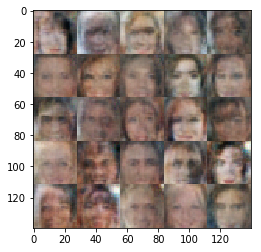

Epoch 1/1... Discriminator Loss: 0.3153... Generator Loss: 4.8395
Epoch 1/1... Discriminator Loss: 0.9599... Generator Loss: 5.9497
Epoch 1/1... Discriminator Loss: 0.5141... Generator Loss: 1.6691
Epoch 1/1... Discriminator Loss: 0.7621... Generator Loss: 2.1549
Epoch 1/1... Discriminator Loss: 0.4880... Generator Loss: 3.8682
Epoch 1/1... Discriminator Loss: 0.2990... Generator Loss: 4.8111
Epoch 1/1... Discriminator Loss: 0.2243... Generator Loss: 4.0144
Epoch 1/1... Discriminator Loss: 0.1613... Generator Loss: 6.3381
Epoch 1/1... Discriminator Loss: 1.5380... Generator Loss: 1.6812
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.6841


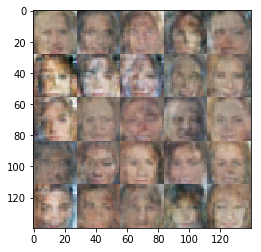

Epoch 1/1... Discriminator Loss: 0.3613... Generator Loss: 3.2526
Epoch 1/1... Discriminator Loss: 0.5097... Generator Loss: 3.1245
Epoch 1/1... Discriminator Loss: 0.5061... Generator Loss: 1.9734
Epoch 1/1... Discriminator Loss: 0.3328... Generator Loss: 4.0206
Epoch 1/1... Discriminator Loss: 0.7004... Generator Loss: 7.8576
Epoch 1/1... Discriminator Loss: 0.2219... Generator Loss: 7.6817
Epoch 1/1... Discriminator Loss: 0.2705... Generator Loss: 3.5640
Epoch 1/1... Discriminator Loss: 0.2120... Generator Loss: 3.1068
Epoch 1/1... Discriminator Loss: 0.3450... Generator Loss: 6.0478
Epoch 1/1... Discriminator Loss: 0.3742... Generator Loss: 4.9827


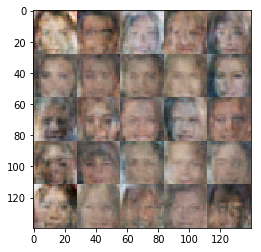

Epoch 1/1... Discriminator Loss: 0.2283... Generator Loss: 4.8725
Epoch 1/1... Discriminator Loss: 0.4239... Generator Loss: 6.7187
Epoch 1/1... Discriminator Loss: 0.2753... Generator Loss: 2.9354
Epoch 1/1... Discriminator Loss: 0.2453... Generator Loss: 4.7499
Epoch 1/1... Discriminator Loss: 0.2947... Generator Loss: 5.9348
Epoch 1/1... Discriminator Loss: 0.1841... Generator Loss: 6.8357


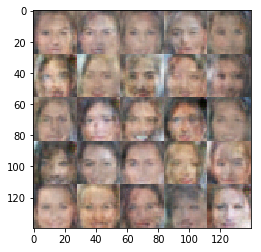

In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.